In [1]:
run Software/lya_emulator/main.py Data/emulator Plots/Emulator hot_cold_training3_rescale_2000 Data/emulator

/share/apps/anaconda/python3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Beginning to initialise LikelihoodClass at 2018-08-30 12:10:34.857566


ValueError: ('Found only', 0, 'of', 11, 'from snaps:', [])

In [2]:
run Software/lya_emulator/main.py /share/hypatia/sbird/Lya_Boss Plots/Emulator hires_s8_new Data/emulator

Beginning to initialise LikelihoodClass at 2018-08-30 12:12:54.582864
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af25ee80>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af155ef0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af25e4a8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af08ecc0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af08ec50>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af08ebe0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af08eda0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af08ee80>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09aef4d198>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09aef4d160>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09aef4d240>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09aef4d748>
Found spectra in <fake_spectra.spectra.Spectra object 

Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60d400>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60d358>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60d438>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60d6a0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60d780>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60d6d8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60d4e0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60d9b0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60da58>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60dc50>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60dcf8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60ddd8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af60de48>
Found spectra in <fake_spectra.spectra.Spectra obje

Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09aed93358>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09aed93860>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09ae980390>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09aed87b70>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09ae73a3c8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09ae72ceb8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09ae72c588>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af26e4a8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09afa17d30>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09afa17e80>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09afa17f60>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09afa17eb8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2b09af90e198>
Number of redshifts for emulator generation = 11
  

    00s19  0034  -4.634853e+04   1.705526e-01 
Runtime:     00s19
Optimization status: Converged


Name : GP regression
Objective : -46348.532948396605
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  sum.linear.variances     |     0.15692023709859426  |      +ve      |        
  sum.rbf.variance         |      1.9780693516324097  |      +ve      |        
  sum.rbf.lengthscale      |       2.801855309983526  |      +ve      |        
  Gaussian_noise.variance  |  2.2240003286210697e-15  |      +ve      |        
  linear.    |  value  |  constraints  |  priors
  variances  |    1.0  |      +ve      |        
  sum.              |  value  |  constraints  |  priors
  linear.variances  |    1.0  |      +ve      |        
  rbf.variance      |    1.0  |      +ve      |        
  rbf.lengthscale   |    1.0  |      +ve      |        
Running L-BFGS-B (Scipy implementati

In [3]:
import seaborn as sb
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [ ]:
output[0].param_limits

In [ ]:
acquisition_function_tau0_amp = output.make_grid_acquisition_function(1, 2, samples=30000, nu=1., exploitation_weight=0.)
acquisition_function_tau0_amp[acquisition_function_tau0_amp == 0.] = np.nan

In [ ]:
acquisition_function_tau0_amp_exploit = output.make_grid_acquisition_function(0, 2, samples=1000, nu=0., exploitation_weight=1.)
acquisition_function_tau0_amp_exploit[acquisition_function_tau0_amp_exploit == 0.] = np.nan

In [ ]:
plt.contour(np.log10(acquisition_function_tau0_amp).T, 100, extent=[0.75, 1.25, 0.8, 1.2], origin='image')
plt.colorbar()

In [ ]:
plt.imshow(np.exp(acquisition_function_tau0_amp).T, extent=[-0.25, 0.25, 0.8, 1.2])
plt.colorbar()

In [ ]:
plt.figure(figsize=(18, 18))
plt.imshow(np.exp(acquisition_function_tau0_amp_exploit - np.nanmax(acquisition_function_tau0_amp_exploit)).T, extent=[-0.25, 0.25, 0.8, 1.2])
plt.colorbar()
#plt.scatter(0.95, 0.95, color='red')

In [ ]:
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.95,]), nu=1., exploitation_weight=0.)
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.9,]), nu=1., exploitation_weight=0.)
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([1.,]), nu=1., exploitation_weight=0.)

In [ ]:
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.95,]), nu=1., exploitation_weight=1.)
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.95,]), nu=0., exploitation_weight=1.)


In [ ]:
output[0].acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.81,]), nu=1., exploitation_weight=None)


In [ ]:
print(np.mean(output[0]._get_emulator_error_averaged_mean_flux(np.array([0.81,]))))

_ = output[0].likelihood(np.array([0., 0.95, 0.81]))
print(np.mean(output[0].emulated_flux_power_std[0]))

print(np.mean(output[0].emulated_flux_power_std[0]) / np.mean(output[0].emulated_flux_power[0]))

In [ ]:
output.cur_results.flatchain.shape

In [ ]:
output.cur_results.get_lnprob(np.array([0., 0.95, 0.95]))

In [ ]:
posterior_samples = np.loadtxt('Data/emulator/AA0.97BB1.3_chain_hot_cold_training3_no_rescale2.txt')

In [ ]:
histogram_output = sb.kdeplot(posterior_samples[:, 2]).get_lines()[0].get_data()

In [ ]:
histogram_output = plt.hist(posterior_samples[:, 2], bins='auto', normed=True, histtype='step', log=True)
print(histogram_output)
plt.axvline(x=0.92)


In [ ]:
print(histogram_output[0].shape)
print(histogram_output[1].shape)
print(histogram_output)

In [ ]:
#n_samples = 200
parameter_samples = (histogram_output[1][:-1] + histogram_output[1][1:]) / 2. #np.linspace(output[0].param_limits[2, 0], output[0].param_limits[2, 1], num=n_samples)
acquisition_function_exploit_array = np.zeros_like(parameter_samples)
for i in range(parameter_samples.shape[0]):
    acquisition_function_exploit_array[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(np.array([parameter_samples[i],]), nu=1., exploitation_weight=None)


In [ ]:
#n_samples = 200
parameter_samples2 = histogram_output[0] #np.linspace(output[0].param_limits[2, 0], output[0].param_limits[2, 1], num=n_samples)
acquisition_function_exploit_array2 = np.zeros_like(parameter_samples2)
for i in range(parameter_samples2.shape[0]):
    acquisition_function_exploit_array2[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(np.array([parameter_samples2[i],]), nu=1., exploitation_weight=None)


In [ ]:
plt.plot(parameter_samples2, np.log(histogram_output[1] / np.max(histogram_output[1])))
plt.xlim([0.89, 1.11])
plt.ylim([-2.5, 0.1])

In [ ]:
plt.plot(parameter_samples2, 100*acquisition_function_exploit_array2[:parameter_samples2.shape[0]])
plt.axvline(x=0.9, color='black', ls=':')
plt.axvline(x=1., color='black', ls=':')
plt.axvline(x=1.1, color='black', ls=':')
plt.xlim([0.89, 1.11])
plt.ylim([0., 0.2])

In [ ]:
plt.plot(parameter_samples2, np.log(histogram_output[1] / np.max(histogram_output[1])), label=r'Exploitation term')
plt.plot(parameter_samples2, 100*acquisition_function_exploit_array2[:parameter_samples2.shape[0]], label=r'Exploration term')
plt.plot(parameter_samples2, np.log(histogram_output[1] / np.max(histogram_output[1])) + 100.*acquisition_function_exploit_array2[:parameter_samples2.shape[0]], label=r'GP-UCB acquisition function')

plt.legend(frameon=False)
#plt.axvline(x=0.9, color='black', ls=':')
plt.axvline(x=0.92, color='blue', ls=':')
plt.axvline(x=0.925, color='green', ls=':')
#plt.axvline(x=0.95, color='black', ls=':')
plt.xlim([0.89, 0.95])
plt.ylim([-0.1, 0.2])
plt.xlabel(r'heat amp')

In [ ]:
output[0].param_limits[0] = np.array([-0.24, 0.24])
print(output[0].param_limits)
output[0].log_likelihood_marginalised_mean_flux(np.array([0.95,]), integration_method='Monte-Carlo', integration_options=6000)


In [5]:
#output[0].param_limits[0] = np.array([-0.007, 0.007])
#output[0].param_limits[1] = np.array([0.948, 0.952])

#mmh.dps = 50
integration_instance = mmh.calculus.quadrature.GaussLegendre
print(integration_instance)

likelihood_marginalised = np.zeros(10)
exploration_term = np.zeros_like(likelihood_marginalised)
#parameter_samples = np.linspace(output[0].param_limits[2, 0] + 0.01, output[0].param_limits[2, 1], num=likelihood_marginalised.shape[0], endpoint=False)
#parameter_samples = np.linspace(0.91, 0.93, num=likelihood_marginalised.shape[0])
parameter_samples = np.ones((likelihood_marginalised.shape[0], output[0].param_limits.shape[0] - 2)) * np.array([0.975, 2.25e-09, 0.08333333333333326, 0.9166666666666666, 0.6916666666666667])[np.newaxis, :]
parameter_samples[:, 3] = np.linspace(output[0].param_limits[5, 0] + 0.01, output[0].param_limits[5, 1], num=likelihood_marginalised.shape[0], endpoint=False)
print(parameter_samples)

for i in range(likelihood_marginalised.shape[0]):
    #parameter_vector = np.array([parameter_samples[i],])
    parameter_vector = parameter_samples[i]
    #likelihood_marginalised[i] = output[0].log_likelihood_marginalised_mean_flux(np.array([parameter_samples[i],]), integration_method='Quadrature', integration_options=integration_instance)
    likelihood_marginalised[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(parameter_vector, nu=0., integration_options='gauss-legendre')
    exploration_term[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(parameter_vector, exploitation_weight=None, nu=1.e4)


<class 'mpmath.calculus.quadrature.GaussLegendre'>
[[9.75000000e-01 2.25000000e-09 8.33333333e-02 5.10000000e-01
  6.91666667e-01]
 [9.75000000e-01 2.25000000e-09 8.33333333e-02 6.09000000e-01
  6.91666667e-01]
 [9.75000000e-01 2.25000000e-09 8.33333333e-02 7.08000000e-01
  6.91666667e-01]
 [9.75000000e-01 2.25000000e-09 8.33333333e-02 8.07000000e-01
  6.91666667e-01]
 [9.75000000e-01 2.25000000e-09 8.33333333e-02 9.06000000e-01
  6.91666667e-01]
 [9.75000000e-01 2.25000000e-09 8.33333333e-02 1.00500000e+00
  6.91666667e-01]
 [9.75000000e-01 2.25000000e-09 8.33333333e-02 1.10400000e+00
  6.91666667e-01]
 [9.75000000e-01 2.25000000e-09 8.33333333e-02 1.20300000e+00
  6.91666667e-01]
 [9.75000000e-01 2.25000000e-09 8.33333333e-02 1.30200000e+00
  6.91666667e-01]
 [9.75000000e-01 2.25000000e-09 8.33333333e-02 1.40100000e+00
  6.91666667e-01]]
Integrating from -0.25 to 0.25 (degree 1 of 6)
Integrating from -0.25 to 0.25 (degree 2 of 6)
(mpf('4.2442091924111727e-651'), mpf('1.58196950705478

In [7]:
#output[0].param_limits[0] = np.array([-0.007, 0.007])
#output[0].param_limits[1] = np.array([0.948, 0.952])

parameter_truth = np.array([0.975, 2.25e-09, 0.08333333333333326, 0.9166666666666666, 0.6916666666666667])

#mmh.dps = 50
integration_instance = mmh.calculus.quadrature.GaussLegendre
print(integration_instance)

likelihood_marginalised = np.zeros(10)
exploration_term = np.zeros_like(likelihood_marginalised)
#parameter_samples = np.linspace(output[0].param_limits[2, 0] + 0.01, output[0].param_limits[2, 1], num=likelihood_marginalised.shape[0], endpoint=False)
#parameter_samples = np.linspace(0.91, 0.93, num=likelihood_marginalised.shape[0])
parameter_samples = np.ones((likelihood_marginalised.shape[0], output[0].param_limits.shape[0] - 2)) * parameter_truth[np.newaxis, :]
parameter_variable = 0
parameter_samples[:, parameter_variable] = np.linspace(output[0].param_limits[parameter_variable+2, 0] + 0.01, output[0].param_limits[parameter_variable+2, 1], num=likelihood_marginalised.shape[0], endpoint=False)
print(parameter_samples)

for i in range(likelihood_marginalised.shape[0]):
    #parameter_vector = np.array([parameter_samples[i],])
    parameter_vector = parameter_samples[i]
    #likelihood_marginalised[i] = output[0].log_likelihood_marginalised_mean_flux(np.array([parameter_samples[i],]), integration_method='Quadrature', integration_options=integration_instance)
    likelihood_marginalised[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(parameter_vector, nu=0., integration_options='gauss-legendre')
    exploration_term[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(parameter_vector, exploitation_weight=None, nu=1.e4)


<class 'mpmath.calculus.quadrature.GaussLegendre'>
[[6.10000000e-01 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]
 [6.99000000e-01 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]
 [7.88000000e-01 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]
 [8.77000000e-01 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]
 [9.66000000e-01 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]
 [1.05500000e+00 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]
 [1.14400000e+00 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]
 [1.23300000e+00 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]
 [1.32200000e+00 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]
 [1.41100000e+00 2.25000000e-09 8.33333333e-02 9.16666667e-01
  6.91666667e-01]]
Integrating from -0.25 to 0.25 (degree 1 of 6)
Integrating from -0.25 to 0.25 (degree 2 of 6)
(mpf('1.6669123106498175e-994'), mpf('1.63279637280440

In [ ]:
plt.scatter(parameter_samples, likelihood_marginalised)


In [ ]:
plt.scatter(parameter_samples, likelihood_marginalised - np.nanmax(likelihood_marginalised))
plt.scatter(parameter_samples, exploration_term, color='red')
plt.plot(histogram_output[0], np.log(histogram_output[1] / np.nanmax(histogram_output[1])), color='blue')
plt.axvline(x=0.92)
plt.xlim([0.89, 0.95])
plt.ylim([-0.2, 0.2])

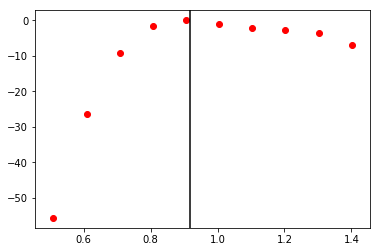

In [6]:
plt.scatter(parameter_samples[:, 3], likelihood_marginalised - np.nanmax(likelihood_marginalised), color='red')
#sb.kdeplot(posterior_samples[:, 2])
#plt.plot(histogram_output[0], np.log(histogram_output[1] / np.nanmax(histogram_output[1])))
plt.axvline(x=0.9166666666666666, color='black')
#plt.xlim([0.905, 0.935])
#plt.ylim([-5., 0.2])

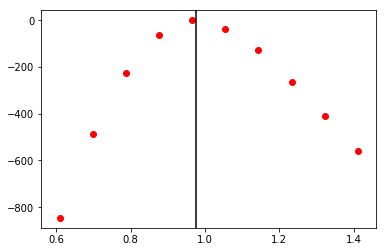

In [8]:
parameter_truth = np.array([0.975, 2.25e-09, 0.08333333333333326, 0.9166666666666666, 0.6916666666666667])

plt.scatter(parameter_samples[:, parameter_variable], likelihood_marginalised - np.nanmax(likelihood_marginalised), color='red')
#sb.kdeplot(posterior_samples[:, 2])
#plt.plot(histogram_output[0], np.log(histogram_output[1] / np.nanmax(histogram_output[1])))
plt.axvline(x=parameter_truth[parameter_variable], color='black')
#plt.xlim([0.905, 0.935])
#plt.ylim([-5., 0.2])

In [ ]:
plt.scatter(parameter_samples, np.exp(likelihood_marginalised - np.nanmax(likelihood_marginalised)), color='red')
#sb.kdeplot(posterior_samples[:, 2])
plt.plot(histogram_output[0], histogram_output[1] / np.nanmax(histogram_output[1]))
plt.axvline(x=0.92, color='black')
plt.xlim([0.8, 1.2])

In [45]:
optimisation_bounds = np.vstack((output[0].param_limits[:,0] + 0.05 * np.absolute(output[0].param_limits[:,0]), output[0].param_limits[:,1] - 0.05 * np.absolute(output[0].param_limits[:,1]))).T
print(output[0].param_limits)
print(optimisation_bounds)


[[-2.50e-01  2.50e-01]
 [ 7.50e-01  1.25e+00]
 [ 6.00e-01  1.50e+00]
 [ 1.20e-09  3.00e-09]
 [-5.00e-01  5.00e-01]
 [ 5.00e-01  1.50e+00]
 [ 6.50e-01  7.50e-01]]
[[-2.3750e-01  2.3750e-01]
 [ 7.8750e-01  1.1875e+00]
 [ 6.3000e-01  1.4250e+00]
 [ 1.2600e-09  2.8500e-09]
 [-4.7500e-01  4.7500e-01]
 [ 5.2500e-01  1.4250e+00]
 [ 6.8250e-01  7.1250e-01]]


In [56]:
#random_starting_point = output[0].param_limits[2:, 0] + npr.rand(5) * (output[0].param_limits[2:, 1] - output[0].param_limits[2:, 0])
random_starting_point = parameter_truth*0.99
print(random_starting_point)

integration_bounds = [[-0.16, 0.16], [0.88, 1.02]]

acquisition_optimisation = output[0].optimise_acquisition_function(random_starting_point, nu=0., optimisation_bounds=optimisation_bounds[2:], integration_bounds=integration_bounds)


[9.6525e-01 2.2275e-09 8.2500e-02 9.0750e-01 6.8475e-01]
Integrating from -0.16 to 0.16 (degree 1 of 6)


 /home/keir/Software/lya_emulator/likelihood.py:392: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Integrating from -0.16 to 0.16 (degree 2 of 6)
(mpf('4.8677387288569564e-629'), mpf('4.8664592268978383e-629'))
Integrating from -0.16 to 0.16 (degree 1 of 6)
Integrating from -0.16 to 0.16 (degree 2 of 6)
(mpf('4.8677413590327412e-629'), mpf('4.8664618533245766e-629'))
Integrating from -0.16 to 0.16 (degree 1 of 6)
Integrating from -0.16 to 0.16 (degree 2 of 6)
(mpf('0.0'), mpf('0.0'))
Integrating from -0.16 to 0.16 (degree 1 of 6)
Integrating from -0.16 to 0.16 (degree 2 of 6)
(mpf('4.8677500207720415e-629'), mpf('4.8664705202386222e-629'))
Integrating from -0.16 to 0.16 (degree 1 of 6)
Integrating from -0.16 to 0.16 (degree 2 of 6)
(mpf('4.8677395362470466e-629'), mpf('4.8664600339872923e-629'))
Integrating from -0.16 to 0.16 (degree 1 of 6)
Integrating from -0.16 to 0.16 (degree 2 of 6)
(mpf('4.8677923259610848e-629'), mpf('4.8665128354021169e-629'))
Integrating from -0.16 to 0.16 (degree 1 of 6)
Integrating from -0.16 to 0.16 (degree 2 of 6)
(mpf('6.3178194729055563e-947'), mpf('6

In [57]:
print(acquisition_optimisation.x)
print(acquisition_optimisation.success)
print(acquisition_optimisation.message)

[9.6525e-01 2.2275e-09 8.2500e-02 9.0750e-01 6.8475e-01]
True
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [58]:
acquisition_optimisation.x - random_starting_point

array([0., 0., 0., 0., 0.])

In [36]:
random_starting_point = output[0].param_limits[2:, 0] + npr.rand(5) * (output[0].param_limits[2:, 1] - output[0].param_limits[2:, 0])
print(random_starting_point)


[1.01256025e+00 1.69050793e-09 4.70441331e-01 1.17147366e+00
 6.80582448e-01]


In [59]:
print(output[0].acquisition_function_GP_UCB_marginalised_mean_flux(parameter_truth, nu=0., integration_bounds=integration_bounds))
print(output[0].acquisition_function_GP_UCB_marginalised_mean_flux(parameter_truth*0.99, nu=0., integration_bounds=integration_bounds))


Integrating from -0.16 to 0.16 (degree 1 of 6)
Integrating from -0.16 to 0.16 (degree 2 of 6)
(mpf('1.3329870108762136e-625'), mpf('1.3329037043281474e-625'))
-1438.8282608244083
Integrating from -0.16 to 0.16 (degree 1 of 6)
Integrating from -0.16 to 0.16 (degree 2 of 6)
(mpf('4.8677387288569564e-629'), mpf('4.8664592268978383e-629'))
-1446.7433939907166


In [41]:
parameter_truth*0.99

array([9.6525e-01, 2.2275e-09, 8.2500e-02, 9.0750e-01, 6.8475e-01])

In [87]:
#parameter_truth_mean_flux = np.array([0., 0.95, 0.975, 2.25e-09, 0.08333333333333326, 0.9166666666666666, 0.6916666666666667])
parameter_truth_mean_flux = output[0].param_limits[:, 0] + npr.rand(7) * (output[0].param_limits[:, 1] - output[0].param_limits[:, 0])

def likelihood_function(parameter_vector_mean_flux):
    print(parameter_vector_mean_flux)
    print(output[0].likelihood(parameter_vector_mean_flux))
    return -1. * output[0].likelihood(parameter_vector_mean_flux)

likelihood_optimisation = spo.basinhopping(likelihood_function, parameter_truth_mean_flux, minimizer_kwargs={'bounds': [tuple(output[0].param_limits[i]) for i in range(7)], 'method': 'L-BFGS-B'})


[-1.59918426e-02  1.24956551e+00  6.81933401e-01  1.91905486e-09
 -4.98870597e-02  5.33542060e-01  7.46028561e-01]
-4983.858110733014
[-1.59918326e-02  1.24956551e+00  6.81933401e-01  1.91905486e-09
 -4.98870597e-02  5.33542060e-01  7.46028561e-01]
-4983.858178137894
[-1.59918426e-02  1.24956552e+00  6.81933401e-01  1.91905486e-09
 -4.98870597e-02  5.33542060e-01  7.46028561e-01]
-4983.858396446491
[-1.59918426e-02  1.24956551e+00  6.81933411e-01  1.91905486e-09
 -4.98870597e-02  5.33542060e-01  7.46028561e-01]
-4983.858109607402
[-1.59918426e-02  1.24956551e+00  6.81933401e-01  1.19190549e-08
 -4.98870597e-02  5.33542060e-01  7.46028561e-01]
-inf
[-1.59918426e-02  1.24956551e+00  6.81933401e-01  1.91905486e-09
 -4.98870497e-02  5.33542060e-01  7.46028561e-01]
-4983.858024389699
[-1.59918426e-02  1.24956551e+00  6.81933401e-01  1.91905486e-09
 -4.98870597e-02  5.33542070e-01  7.46028561e-01]
-4983.858165232625
[-1.59918426e-02  1.24956551e+00  6.81933401e-01  1.91905486e-09
 -4.9887059

AssertionError: 

In [81]:
print(likelihood_function(parameter_truth_mean_flux))
print(likelihood_function(np.array([0., 0.95, 0.975, 2.25e-09, 0.08333333333333326, 0.9166666666666666, 0.6916666666666667])))

print(likelihood_optimisation.x, likelihood_optimisation.success, likelihood_optimisation.message)
print(likelihood_optimisation.x - parameter_truth_mean_flux)


[4.52544122e-03 9.62113198e-01 7.01434517e-01 2.85763321e-09
 2.85108637e-01 1.00409233e+00 7.35849838e-01] -2261.913676512134
2261.913676512134
[0.00000000e+00 9.50000000e-01 9.75000000e-01 2.25000000e-09
 8.33333333e-02 9.16666667e-01 6.91666667e-01] -1433.0701952056331
1433.0701952056331
[4.52544122e-03 9.62113198e-01 7.01434517e-01 2.85763321e-09
 2.85108637e-01 1.00409233e+00 7.35849838e-01] True b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
[0. 0. 0. 0. 0. 0. 0.]
